<a href="https://colab.research.google.com/github/aboutdouglas/Processamento_Linguagem_Natural/blob/main/Word_Embedding%2C_Word2Vec_e_Redes_Neurais_Convencionais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Pós Graduação/Bases/IMDB_Dataset.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
import sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=0)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (40000,)
y_train shape: (40000,)
X_test shape: (10000,)
y_test shape: (10000,)


Comecemos utilizando a classe Tokenizer, que pode vetorizar um corpus de texto em uma lista de inteiros, os quais representam o índice da palavra no dicionário que codifica todo o corpus. O parâmetro "num_words" define o tamanho máximo desse dicionário. 

In [4]:
%%time
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
tk_X_train = tokenizer.texts_to_sequences(X_train)
tk_X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
print(X_train[0])
print(tk_X_train[0])

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

Conforme pode ser observado acima, em vez de trabalhar com um vetor de 10000 colunas para representar o dicionário, conseguimos reduzir bastante a dimensionalidade. As palavras são colocadas no dicionário ordenadas a partir das possuem maior frequência. Veja, a seguir, alguns exemplos.

In [5]:
for word in ['movie', 'film', 'the', 'one']:
  print('{}: {}'.format(word, tokenizer.word_index[word]))


movie: 17
film: 19
the: 1
one: 27


O único obstáculo é que cada sentença terá um tamanho diferente, pois cada sentença tem um número de tokens próprio. Para resolver isso, podemos identificar qual o valor máximo e, depois, preencher o vetor com zeros. Vamos identificar primeiro o maior vetor: 

In [6]:
print('Max size:', max([len(i) for i in tk_X_train]))

Max size: 2211


Em seguida, é necessário realizar o padding para preencher com zeros:

In [7]:
from keras.preprocessing.sequence import pad_sequences

maxlen = max([len(i) for i in tk_X_train])
tk_pad_X_train  = pad_sequences(tk_X_train, padding='post', maxlen=maxlen)
tk_pad_X_test = pad_sequences(tk_X_test, padding='post', maxlen=maxlen)
print(tk_pad_X_train[0,:])

[196  41   1 ...   0   0   0]


Agora, temos, no máximo, um vetor com 2211 colunas, que é o máximo de palavras que uma review possui. Neste momento, vamos codificar a saída esperada (Target), conforme já feito anteriormente:

In [8]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

ohe_y_train = lb.fit_transform(y_train)
ohe_y_test = lb.fit_transform(y_test)
print('ohe_y_train shape:', ohe_y_train.shape)
print('ohe_y_test shape:', ohe_y_test.shape)

ohe_y_train shape: (40000, 1)
ohe_y_test shape: (10000, 1)


Podemos, agora, utilizar a classe Embedding do Keras para incorporar essa nova codificação. Essa camada Embedding pega os inteiros calculados anteriormente e os mapeia para um vetor denso de incorporação. Mas, antes, vamos fazer as importações necessárias, conforme a seguir.

In [9]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, GlobalMaxPool1D, Dropout, Conv1D, GlobalMaxPool1D
import tensorflow
from keras.optimizers import adam_v2 as Adam

E definir os hiperparâmetros do treinamento:

In [10]:
from keras.optimizer_v1 import Optimizer
NB_EPOCH = 20
BATCH_SIZE = 128
VERBOSE = 1
OPTIMIZER = Adam

Agora, sim, vamos definir uma arquitetura de rede neural:

In [11]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=maxlen))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2211, 50)          5606350   
                                                                 
 flatten (Flatten)           (None, 110550)            0         
                                                                 
 dense (Dense)               (None, 10)                1105510   
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 6,711,871
Trainable params: 6,711,871
Non-trainable params: 0
_________________________________________________________________


Veja que esta já é uma rede de bem mais parâmetros. Vamos treinar com o uso de GPU e ver o resultado.

In [12]:
%%time
history = model.fit(tk_pad_X_train, ohe_y_train, epochs=NB_EPOCH, verbose=1, validation_data=(tk_pad_X_test, ohe_y_test),
                    batch_size=BATCH_SIZE)

Epoch 1/20
313/313 [==============================] - 50s 156ms/step - loss: 0.4708 - accuracy: 0.7581 - val_loss: 0.2928 - val_accuracy: 0.8785
Epoch 2/20
313/313 [==============================] - 47s 151ms/step - loss: 0.2227 - accuracy: 0.9137 - val_loss: 0.2688 - val_accuracy: 0.8912
Epoch 3/20
313/313 [==============================] - 47s 151ms/step - loss: 0.1518 - accuracy: 0.9458 - val_loss: 0.2834 - val_accuracy: 0.8867
Epoch 4/20
313/313 [==============================] - 47s 151ms/step - loss: 0.0903 - accuracy: 0.9750 - val_loss: 0.3004 - val_accuracy: 0.8914
Epoch 5/20
313/313 [==============================] - 47s 151ms/step - loss: 0.0437 - accuracy: 0.9925 - val_loss: 0.3377 - val_accuracy: 0.8885
Epoch 6/20
313/313 [==============================] - 47s 151ms/step - loss: 0.0210 - accuracy: 0.9977 - val_loss: 0.3709 - val_accuracy: 0.8859
Epoch 7/20
313/313 [==============================] - 47s 151ms/step - loss: 0.0106 - accuracy: 0.9991 - val_loss: 0.3947 - val_ac

Vamos calcular a acurácia:

In [13]:
loss, accuracy = model.evaluate(tk_pad_X_test, ohe_y_test, verbose=False)
print("Acurácia do Teste: {:.4f}".format(accuracy))

Acurácia do Teste: 0.8826


Veja que obtivemos 88,25%.

Vamos definir uma função para plotar a acurácia e perda do treino e teste.

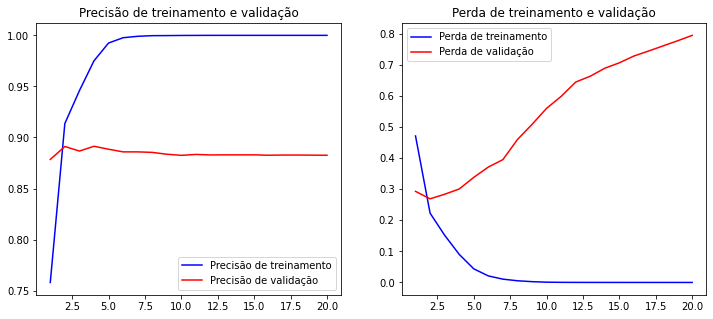

In [14]:
import matplotlib
import matplotlib.pyplot as plt

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)
  plt.figure(figsize=(12,5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Precisão de treinamento')
  plt.plot(x, val_acc, 'r', label='Precisão de validação')
  plt.title('Precisão de treinamento e validação')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Perda de treinamento')
  plt.plot(x, val_loss, 'r', label='Perda de validação')
  plt.title('Perda de treinamento e validação')
  plt.legend()

plot_history(history)

Conforme visto acima, o treinamento chegou próximo de 100% para os dados de treino, mas não para os dados de teste. Isso pode ser pelo fato de não termos adicionado uma camada Dropout. Veja que o resultado não alterou após uma quantidade de épocas, logo, vamos limitar a execução para 10 épocas. Além disso, vamos adicionar à nossa rede uma camada Max Pooling após o Embedding, como uma forma de reduzir o tamanho dos vetores de entrada.

In [15]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=maxlen))
model.add(GlobalMaxPool1D())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics=['accuracy'])
model.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2211, 50)          5606350   
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 16)                816       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5,607,183
Trainable params: 5,607,183
Non-trainable params: 0
____________________________________________

Vamos treinar e ver o resultado.

In [16]:
%%time
history = model.fit(tk_pad_X_train, ohe_y_train, epochs=NB_EPOCH, verbose=1,
                    validation_data=(tk_pad_X_test, ohe_y_test),
                    batch_size=BATCH_SIZE)

Epoch 1/20
313/313 [==============================] - 49s 155ms/step - loss: 0.6116 - accuracy: 0.6844 - val_loss: 0.4357 - val_accuracy: 0.8486
Epoch 2/20
313/313 [==============================] - 48s 153ms/step - loss: 0.3867 - accuracy: 0.8506 - val_loss: 0.3153 - val_accuracy: 0.8683
Epoch 3/20
313/313 [==============================] - 49s 157ms/step - loss: 0.2954 - accuracy: 0.8909 - val_loss: 0.2897 - val_accuracy: 0.8767
Epoch 4/20
313/313 [==============================] - 48s 154ms/step - loss: 0.2472 - accuracy: 0.9152 - val_loss: 0.2832 - val_accuracy: 0.8821
Epoch 5/20
313/313 [==============================] - 48s 154ms/step - loss: 0.2096 - accuracy: 0.9324 - val_loss: 0.2891 - val_accuracy: 0.8808
Epoch 6/20
313/313 [==============================] - 48s 154ms/step - loss: 0.1773 - accuracy: 0.9457 - val_loss: 0.3005 - val_accuracy: 0.8812
Epoch 7/20
313/313 [==============================] - 48s 155ms/step - loss: 0.1475 - accuracy: 0.9571 - val_loss: 0.3236 - val_ac

Vamos calcular a acurácia:

In [17]:
loss, accuracy = model.evaluate(tk_pad_X_test, ohe_y_test, verbose=False)
print('Acurácia do Teste: {:.4f}'.format(accuracy))

Acurácia do Teste: 0.8686


Na próxima imagem, podemos ver novamente os gráficos do treinamento: primeiramente da acurácia (que queremos maximizar); e outro da função de perda (que queremos minimizar). As linhas azuis se referem ao resultado com dados de treino, e a vermelha aos dados de teste.

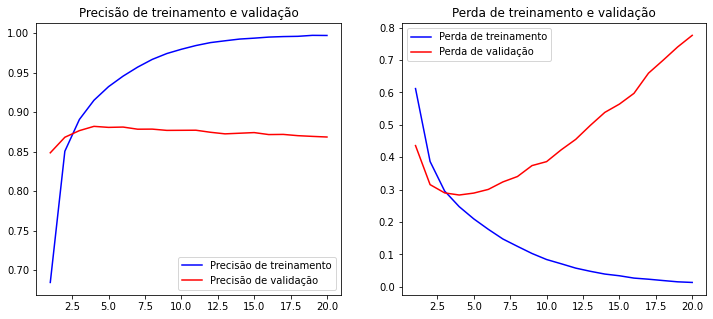

In [18]:
plot_history(history)

Na figura acima, podemos observar o resultado do treinamento do nosso modelo por meio dos gráficos de acurácia (accuracy) e função de perda (validation loss). Podemos perceber que, com os dados de treino, obtivemos um resultado bem satisfatório, acima de 0.95 de acurácia e com perda abaixo de 0.1. No entanto, com os dados de treinos, o resultado ficou cerca de 0.87.

In [19]:
%cd drive/MyDrive/'Colab Notebooks'

/content/drive/MyDrive/Colab Notebooks


CNN

CNN processa considerando a proximidade das palavras e identificar os melhores mapas de atributos (feature maps) que serão úteis para o processo de classificação.

In [21]:
NB_EPOCH = 3
BATCH_SIZE = 128
VERBOSE = 1
OPTIMIZER = Adam

Após definir os hiperparâmetros, vamos definir a rede neural CNN:

In [24]:
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=maxlen))
model.add(Conv1D(64, 5, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Flatten())
model.add(Dropout(rate=0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 2211, 128)         14352256  
                                                                 
 conv1d_1 (Conv1D)           (None, 2207, 64)          41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                      

Treinamento

In [25]:
%%time
history = model.fit(tk_pad_X_train, ohe_y_train,
                    epochs=NB_EPOCH,
                    verbose=1,
                    validation_data=(tk_pad_X_test, ohe_y_test),
                    batch_size=BATCH_SIZE)

Epoch 1/3
313/313 [==============================] - 592s 2s/step - loss: 0.5268 - accuracy: 0.7193 - val_loss: 0.3127 - val_accuracy: 0.8724
Epoch 2/3
313/313 [==============================] - 587s 2s/step - loss: 0.2836 - accuracy: 0.8901 - val_loss: 0.2614 - val_accuracy: 0.8920
Epoch 3/3
313/313 [==============================] - 587s 2s/step - loss: 0.1898 - accuracy: 0.9325 - val_loss: 0.2696 - val_accuracy: 0.8916
CPU times: user 55min 59s, sys: 46.1 s, total: 56min 45s
Wall time: 30min 22s


Resultado

In [26]:
loss, accuracy = model.evaluate(tk_pad_X_test, ohe_y_test, verbose=False)
print("Acurácia do Teste:  {:.4f}".format(accuracy))

Acurácia do Teste:  0.8916


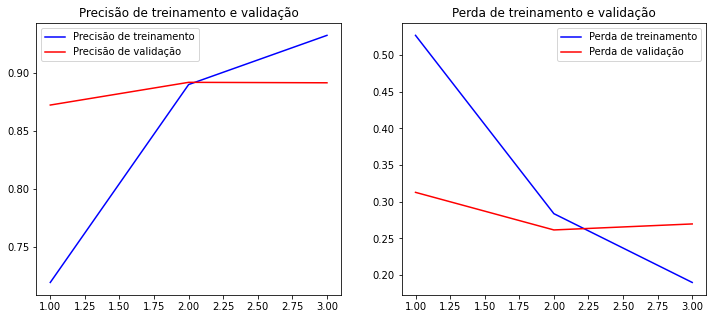

In [27]:
plot_history(history)